<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/%E5%BC%95%E3%81%A3%E8%B6%8A%E3%81%97%E4%BA%88%E6%B8%ACbaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリのインポート

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# pip install catboost

In [4]:
# 初期設定
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

import joblib

from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
is_plot = True

# データの読み込み

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv')
pd.set_option('display.max_columns', None)
df_train.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1


# 簡単なデータの確認

In [7]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    return info_df

print(df_train.shape)
information_df(df_train)

(2101, 6)


,dtypes,NaN Count,Nunique,Unique Values
datetime,object,0,2101,"[2010-07-01, 2010-07-02, 2010-07-03, 2010-07-0..."
y,int64,0,99,"[17, 18, 20, 14, 4, 10, 12, 21, 15, 11, 8, 13,..."
client,int64,0,2,"[0, 1]"
close,int64,0,2,"[0, 1]"
price_am,int64,0,7,"[-1, 0, 1, 2, 3, 5, 4]"
price_pm,int64,0,7,"[-1, 0, 1, 2, 3, 4, 5]"




*   求める引っ越し数は１６年度の数字。１６年度より前の過去実績から傾向を予測。
*   一般的に、年間を通して見ると、月別の移動者数（≒引越し者数）は特定の月に大きく偏っている。3月、4月が圧倒的に多く、3月は他の月のおよそ2.5倍、4月はおよそ2倍となっている。
*   clientは法人が絡む特殊な引越し日（オフィス引っ越しなど）
*   closeは休業日
*   priceは料金表。どれくらいの料金かは現状不明。-1は欠損値なので注意。
*   現在の単身の引っ越し見積もり料金相場は、通常期（5月～2月）で28,000円～31,050円、繁忙期（3月・4月）で35,100円～40,000円です。繁忙期は価格が高そう。
*   対応範囲は北海道、宮城、東京、神奈川、埼玉、千葉、愛知、三重、岐阜、大阪、兵庫、京都、奈良、滋賀、広島、福岡、佐賀、熊本、大分



因数分解

引っ越し数 = 総引っ越し数（法人/個人）×対応範囲率（※発着で対応可）×業者選択率

業者選択率：価格、納期（日程）、品質・評判

# 学習データの確認

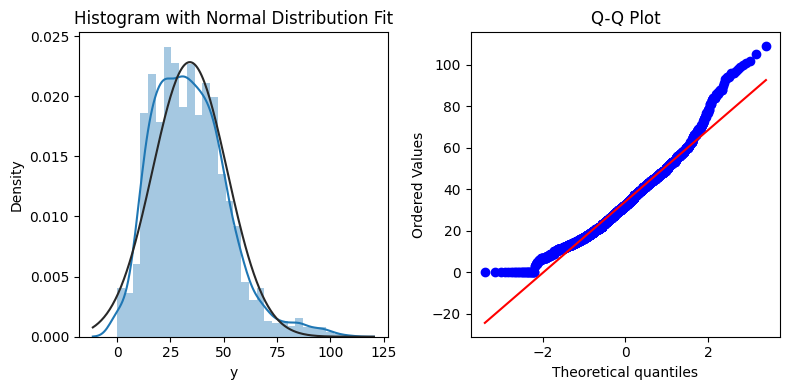

Skewness: 0.7722613806564008
Kurtosis: 1.016158321466305


In [8]:
# 学習データの分布の確認
def normal_distribution_fit(col):
  fig, ax = plt.subplots(1, 2, figsize=(8, 4))

  sns.distplot(df_train[col], fit=norm, ax=ax[0])
  ax[0].set_title('Histogram with Normal Distribution Fit')

  stats.probplot(df_train[col], plot=ax[1])
  ax[1].set_title('Q-Q Plot')

  plt.tight_layout()
  plt.show()

  print(f"Skewness: {df_train[col].skew()}")
  print(f"Kurtosis: {df_train[col].kurt()}")

normal_distribution_fit('y')

正規分布に近い形となっている。logを取るとどうなるか。

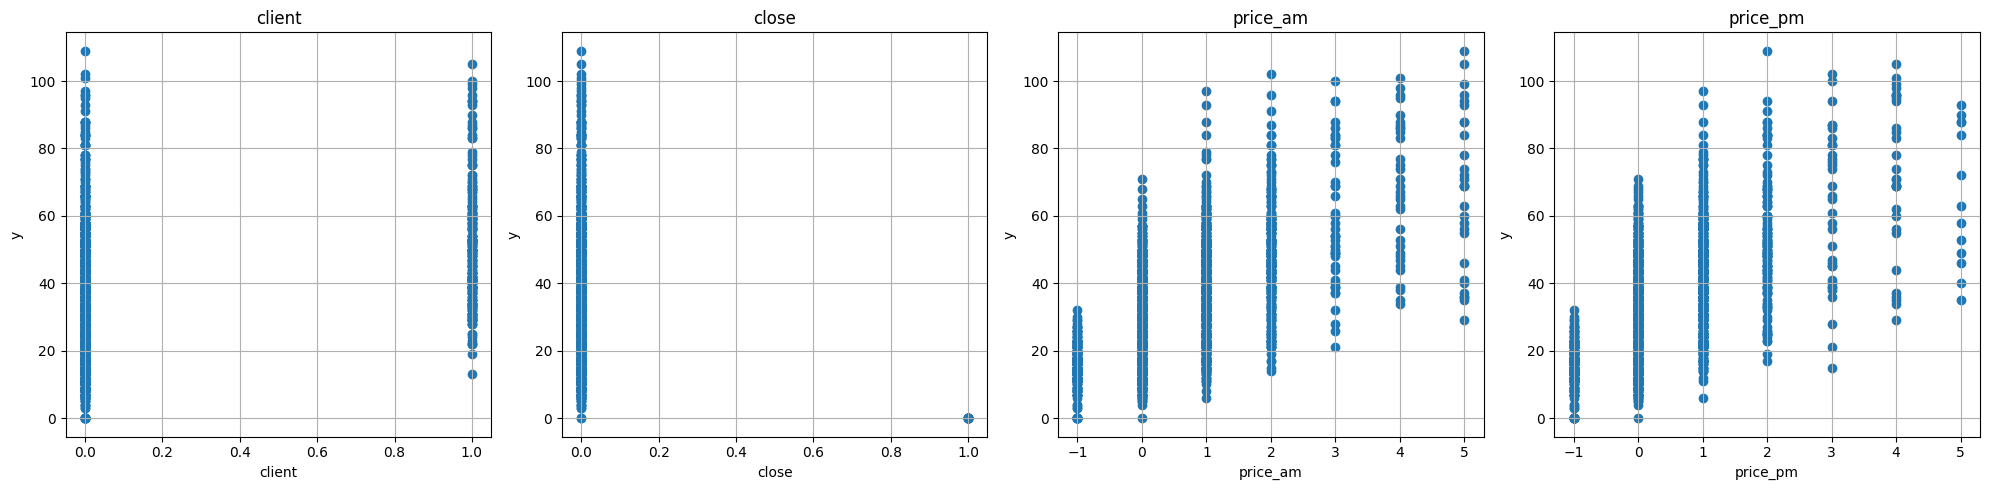

In [9]:
def scatter_plot(x_cols):
  plt.figure(figsize=(len(x_cols)*5, 5))

  for i, col in enumerate(x_cols, start=1):
      plt.subplot(1, len(x_cols), i)
      plt.scatter(x=df_train[col], y=df_train["y"])
      plt.title(col)
      plt.xlabel(col)
      plt.ylabel("y")
      # plt.ylim(0, 800000)
      plt.grid(True)

  plt.tight_layout()
  plt.show()

plot_cols = ["client", "close", "price_am", "price_pm"]

if is_plot == True:
  scatter_plot(plot_cols)



*   日付を数値化する。曜日を定義。カレンダーを定義。
*   clientはそのままかな
*   closeは曜日やカレンダーと合わせるとデータの価値が出そう
*   金額は欠損値を平均としていいか。他の数字のほうがいいか



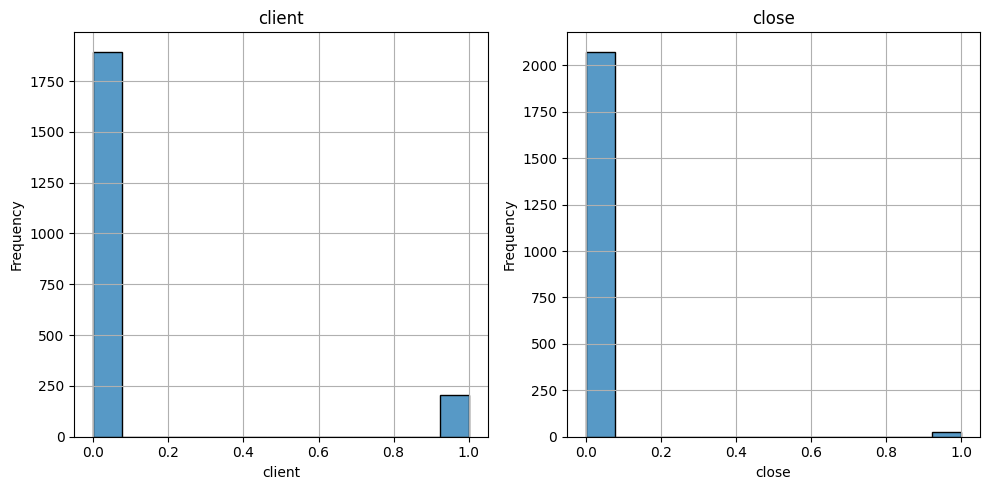

In [21]:
def hist_plot(x_cols):
  plt.figure(figsize=(len(x_cols)*5, 5))

  for i, col in enumerate(x_cols, start=1):
      plt.subplot(1, len(x_cols), i)
      sns.histplot(df_train[col])
      plt.title(col)
      plt.xlabel(col)
      plt.ylabel("Frequency")
      # plt.ylim(0, 800000)
      plt.grid(True)

  plt.tight_layout()
  plt.show()
plot_cols = ["client", 'close']
if is_plot == True:
  hist_plot(plot_cols)

# 特徴量選択

In [11]:
features = [
    'price_am', 'price_pm'
]

In [12]:
X_train = df_train[features]
y_train = df_train['y']

print(X_train.shape)
print(y_train.shape)

(2101, 2)
(2101,)


# モデル作成

In [13]:
# 初期値
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

In [14]:
# 初期設定で使用
n_splits = 5

cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = []
imp = pd.DataFrame()

for nfold, (train_idx, val_idx) in enumerate(cv.split(X_train)):
    x_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = X_train.iloc[val_idx], y_train.iloc[val_idx]

    print("train:", x_tr.shape, y_tr.shape)
    print("val:", x_va.shape, y_va.shape)

    model = lgb.LGBMRegressor(**params)

    model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0)
        ],
    )

    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)

    mae_tr = np.sqrt(mean_absolute_error(y_tr, y_tr_pred))
    mae_va = np.sqrt(mean_absolute_error(y_va, y_va_pred))

    print("[MAE] tr: {:.2f}, va: {:.2f}".format(mae_tr, mae_va))

    metrics.append([nfold, mae_tr, mae_va])

    _imp = pd.DataFrame({
        "col": X_train.columns,
        "imp": model.feature_importances_,
        'nfold': nfold
        })

    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

train: (1680, 2) (1680,)
val: (421, 2) (421,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 1680, number of used features: 2
[LightGBM] [Info] Start training from score 34.012500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [15]:
metrics = np.array(metrics)
print(metrics)

print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),
))

[[0.         3.23727973 3.26336481]
 [1.         3.20922754 3.33587694]
 [2.         3.25469948 3.2059642 ]
 [3.         3.24742144 3.17128866]
 [4.         3.22741773 3.25193598]]
[cv ] tr: 3.24+-0.02, va: 3.25+-0.06


In [16]:
imp = imp.groupby("col")["imp"].agg(["mean", "std"])
imp.columns = ["imp", "imp_std"]

imp_df = imp.sort_values(by='imp', ascending=False)
imp_df.head(30)

,imp,imp_std
col,,
price_am,1.026118e+06,101087.170115
price_pm,1.375512e+05,101471.947069


# Submission

In [17]:
test = pd.read_csv('/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv')
test.shape

(365, 5)

In [18]:
X_test = test[features]
X_test.shape

(365, 2)

In [19]:
y_test_pred = model.predict(X_test)

df_submit = pd.DataFrame({
    'datetime': test["datetime"],
    'y': y_test_pred
})

df_submit.head()

,datetime,y
0,2016-04-01,56.898295
1,2016-04-02,67.292033
2,2016-04-03,49.522888
3,2016-04-04,40.908306
4,2016-04-05,40.908306


In [20]:
df_submit.to_csv("submission1.csv", index=False, header=False)